In [2]:
import os
import pandas as pd
import numpy as np

# Paths to data
data_folder = r"C:\Users\sejac\Desktop\csv_labels"
top_bins_path = r"C:\Users\sejac\Desktop\top_10000_bins_u_test.csv"

# Function to calculate z-scores with special handling for zero entries
def calculate_z_scores(data):
    # Exclude zeros when calculating mean and standard deviation
    non_zero_data = data[data != 0]
    mean = non_zero_data.mean()
    std = non_zero_data.std()

    # Avoid division by zero in case all non-zero values are the same
    if std == 0:
        return np.zeros_like(data)  # Return all zeros if standard deviation is zero

    # Calculate z-scores for non-zero values
    z_scores = (data - mean) / std
    z_scores[data == 0] = 0  # Keep zeros as zero
    return z_scores

# Load top 1000 bins
top_bins = pd.read_csv(top_bins_path)['Bin_ID']

# Initialize list to store all patients' data
all_patients_data = []

# Loop through all patient files
for filename in os.listdir(data_folder):
    if filename.endswith(".csv"):
        # Determine cancer label from filename
        if "_0_" in filename:
            label = 0  # Non-cancer
        elif "_1_" in filename:
            label = 1  # Cancer
        else:
            raise ValueError(f"Unexpected filename format: {filename}")
        
        # Load patient data
        file_path = os.path.join(data_folder, filename)
        patient_data = pd.read_csv(file_path)
        
        # Create unique Bin_ID (Chromosome + Start)
        patient_data['Bin_ID'] = patient_data['Chromosome'] + ":" + patient_data['Start'].astype(str)
        
        # Filter for top bins
        patient_data = patient_data[patient_data['Bin_ID'].isin(top_bins)]
        
        # Ensure consistent data length (after filtering for top bins)
        if len(patient_data) != len(top_bins):
            print(f"Inconsistent data length for {filename}. Skipping.")
            continue
        
        # Normalize Percent_Methylation using z-scores
        normalized_methylation = calculate_z_scores(patient_data['Percent_Methylation'].values)
        patient_data['Percent_Methylation'] = normalized_methylation
        
        # Set Bin_ID as the index for easier merging later
        patient_data = patient_data.set_index('Bin_ID')['Percent_Methylation']
        
        # Add label and patient identifier
        patient_data = patient_data.to_frame(name=filename).T  # Transpose for merging
        patient_data['Label'] = label  # Add label column
        
        # Append to list
        all_patients_data.append(patient_data)

# Combine all patient data into a single DataFrame
final_data = pd.concat(all_patients_data).reset_index(drop=True)

# Extract labels
labels = final_data['Label']
features = final_data.drop('Label', axis=1)

# Fill missing values with column mean (optional, but unlikely needed after z-normalization)
features.fillna(features.mean(), inplace=True)

print("Data normalization and preparation completed.")
print(f"Features shape: {features.shape}, Labels shape: {labels.shape}")


Data normalization and preparation completed.
Features shape: (517, 10000), Labels shape: (517,)


In [3]:
# Display dataset
print("Processed Data:")
print(features)
print("Labels:")
print(labels)

Processed Data:
Bin_ID  chr1:342892  chr1:374064  chr1:405236  chr1:467580  chr1:498752  \
0         -1.195785    -0.101241    -1.002667     0.113597     0.682742   
1         -1.328902    -0.910295    -0.636373    -0.195101    -0.012782   
2         -1.199445    -0.560960    -1.399833     0.099303    -0.044552   
3         -1.349904    -0.718146     0.184804    -0.108753     0.185279   
4         -1.283554    -0.161783    -1.021322    -0.315495     0.020575   
..              ...          ...          ...          ...          ...   
512       -0.050302     0.151262    -1.175596    -0.225259     0.768087   
513       -1.460096     0.160212    -0.558913    -0.215324     0.185421   
514       -0.711831     0.284432    -0.525591    -0.832630     0.377175   
515       -1.399134    -0.801798    -0.143709     0.627115     0.347593   
516       -0.648679    -0.900291    -1.138890     0.227859     0.227859   

Bin_ID  chr1:561096  chr1:623440  chr1:654612  chr1:748128  chr1:779300  ...  \
0  

In [4]:
print(f"Features shape: {features.shape}")  # Should be (num_patients, 1000)
print(f"Labels shape: {labels.shape}")      # Should match the number of patients
print(f"Sample labels: {labels.head()}")    # Verify label values

Features shape: (517, 10000)
Labels shape: (517,)
Sample labels: 0    0
1    0
2    0
3    1
4    0
Name: Label, dtype: int64


In [5]:
from sklearn.model_selection import train_test_split

# Split into training (60%), validation (20%), and test (20%) sets
X_train, X_temp, y_train, y_temp = train_test_split(features, labels, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")


Training set: (310, 10000)
Validation set: (103, 10000)
Test set: (104, 10000)


In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Initialize Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)

# Train the model
rf_model.fit(X_train, y_train)

# Evaluate on validation set
y_val_pred = rf_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)

print(f"Validation Accuracy: {val_accuracy:.4f}")


Validation Accuracy: 0.6893


In [7]:
from sklearn.metrics import classification_report

# Predict on the test set
y_test_pred = rf_model.predict(X_test)

# Compute accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)

# Display results
print(f"Test Accuracy: {test_accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_test_pred))


Test Accuracy: 0.6923
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.70      0.71        56
           1       0.66      0.69      0.67        48

    accuracy                           0.69       104
   macro avg       0.69      0.69      0.69       104
weighted avg       0.69      0.69      0.69       104



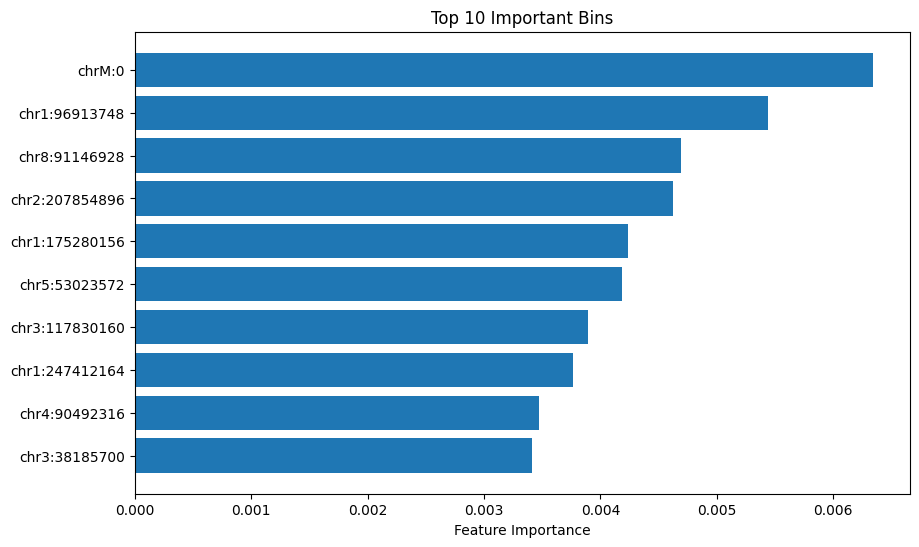

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Extract feature importances
importances = rf_model.feature_importances_
sorted_indices = np.argsort(importances)[::-1]
top_features = features.columns[sorted_indices[:10]]

# Plot top 10 features
plt.figure(figsize=(10, 6))
plt.barh(range(len(top_features)), importances[sorted_indices[:10]], align='center')
plt.yticks(range(len(top_features)), top_features)
plt.xlabel('Feature Importance')
plt.title('Top 10 Important Bins')
plt.gca().invert_yaxis()
plt.show()


In [9]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
}

# Perform grid search
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best parameters
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best CV Accuracy: {grid_search.best_score_:.4f}")

# Use best model for testing
best_rf_model = grid_search.best_estimator_
y_test_pred_best = best_rf_model.predict(X_test)
print(f"Test Accuracy (Best Model): {accuracy_score(y_test, y_test_pred_best):.4f}")


Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}
Best CV Accuracy: 0.7613
Test Accuracy (Best Model): 0.7019


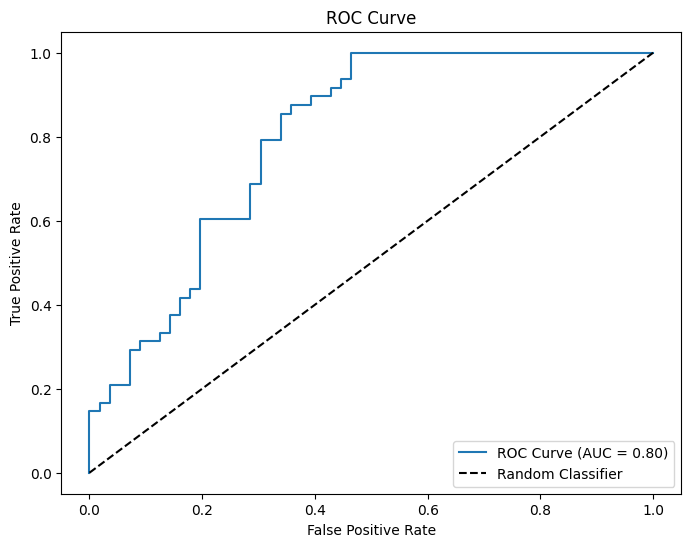

In [10]:
from sklearn.metrics import roc_auc_score, roc_curve

# Compute probabilities and AUC
y_test_proba = rf_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_test_proba)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()
